# Model Fitting in Python

In [1]:
# import packages
from lmfit import Minimizer, Parameters, report_fit
import numpy as np
import matplotlib.pylab as plt

In [4]:
# Create random data
t = np.arange(0, 24, 2)
N = np.array([32500, 33000, 38000, 105000, 445000, 1430000, 3020000, 4720000, 5670000, 5870000, 5930000, 5940000])
np.random.seed(1234) # Set random seed for reproducibility
N_rand = N * (1 + np.random.normal(scale = 0.1, size = len(N)))

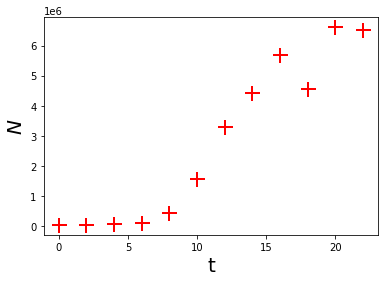

In [5]:
# Plotting the figure
plt.plot(t, N_rand, 'r+', markersize = 15, markeredgewidth = 2, label = 'Data')
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$N$', fontsize = 20)
plt.ticklabel_format(style="scientific", scilimits=[0, 3])

In [67]:
# Create object for storing parameters
params_linear = Parameters()

# Add parameters and initial values to it
params_linear.add('a', value = 1)
params_linear.add('b', value = 1)
params_linear.add('c', value = 1)
params_linear.add('d', value = 1)

1

In [7]:
# Write down the objective function that we want to minimize
def residuals_linear(params, t, data):
    """
    Calculate cubic growth and substract data
    """
    
    # Get an ordered dictionary of parameter values
    v = params.valuesdict()
    
    # Cubic model
    model = v['a'] * t ** 3 + v['b'] * t ** 2 + v['c'] * t + v['d']
    return model - data # Return residual

## Fitting poly model using NLLS

In [11]:
# Create a Minimizer object
minner = Minimizer(residuals_linear, params_linear, fcn_args = (t, np.log(N_rand)))

# Perform the minimization
fit_linear_NLLS = minner.minimize()
report_fit(fit_linear_NLLS)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 12
    # variables        = 4
    chi-square         = 1.68617886
    reduced chi-square = 0.21077236
    Akaike info crit   = -15.5493005
    Bayesian info crit = -13.6096739
[[Variables]]
    a: -0.00147820 +/- 5.3322e-04 (36.07%) (init = 1)
    b:  0.03687009 +/- 0.01787451 (48.48%) (init = 1)
    c:  0.14339899 +/- 0.16467922 (114.84%) (init = 1)
    d:  10.0545124 +/- 0.39977042 (3.98%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.984
    C(b, c) = -0.960
    C(a, c) =  0.900
    C(c, d) = -0.779
    C(b, d) =  0.621
    C(a, d) = -0.528


## Fitting poly model using OLS

In [12]:
# Using OLS
fit_linear_OLS = np.polyfit(t, np.log(N_rand), 3)
print(fit_linear_OLS)

[-1.47819938e-03  3.68700893e-02  1.43398989e-01  1.00545124e+01]


## Comparing the NLLS and OLS fits

In [16]:
fit_linear_NLLS.params
par_dict = fit_linear_NLLS.params.valuesdict().values()

# Transform these into an array
par = np.array(list(par_dict))
print("The difference between NLLS and OLS: ",fit_linear_OLS - par)

The difference between NLLS and OLS:  [ 2.18245647e-12  2.18892265e-12  7.72548692e-13 -1.61293201e-11]


### Calculating the residuals

In [19]:
# Construct the fitted polynomial equation
my_poly = np.poly1d(fit_linear_OLS)

# Compute predicted values
ypred = my_poly(t)

# Calculating residuals
residuals = ypred - np.log(N_rand)

# Calculating residuals for NLLS
residuals_NLLS = residuals_linear(fit_linear_NLLS.params, t, np.log(N_rand))

print("The difference of residuals between NLLS and oLS:", residuals_NLLS - residuals)

The difference of residuals between NLLS and oLS: [ 1.61293201e-11 -1.16298082e-11 -1.61662683e-10 -5.38717515e-10
 -1.24756028e-09 -2.39294451e-09 -4.07963086e-09 -6.41237641e-09
 -9.49593648e-09 -1.34350735e-08 -1.83345428e-08 -2.42990996e-08]


## Fitting non-linear models to the data
### 1. Logistic Model

In [20]:
# Create object for parameter storing
params_logistic = Parameters()
params_logistic.add('N_0', value = N_rand[0])
params_logistic.add('N_max', value = N_rand[-1])

# Recall the value for growth rate obtained from a linear fit
params_logistic.add('r', value = 0.62)

In [21]:
# Write down the objective function that we want to minimize
def residuals_logistic(params, t, data):
    ''' Model a logistic growth and subtract data '''
    # Get an ordered dictionary of parameter values
    v = params.valuesdict()
    # Logistic model
    model = np.log(v['N_0'] * v['N_max'] * np.exp(v['r'] * t) / \
    (v['N_max'] + v['N_0'] * ( np.exp(v['r'] * t) - 1)))
    # Return residuals
    return model - data

In [22]:
# Create a Minimizer object
minner = Minimizer(residuals_logistic, params_logistic, fcn_args = (t, np.log(N_rand)))
# Perform the minimization
fit_logistic = minner.minimize(method = 'leastsq')

In [23]:
# Get summary of the fit
report_fit(fit_logistic)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 12
    # variables        = 3
    chi-square         = 2.19693074
    reduced chi-square = 0.24410342
    Akaike info crit   = -14.3741446
    Bayesian info crit = -12.9194246
[[Variables]]
    N_0:    13998.5739 +/- 4769.60185 (34.07%) (init = 34032.16)
    N_max:  7108406.32 +/- 2165947.53 (30.47%) (init = 6529216)
    r:      0.44848151 +/- 0.05161938 (11.51%) (init = 0.62)
[[Correlations]] (unreported correlations are < 0.100)
    C(N_0, r)     = -0.807
    C(N_max, r)   = -0.448
    C(N_0, N_max) =  0.239


### 2. Gompertz Model

In [24]:
# create object for parameter storing
params_gompertz = Parameters()
# add with tuples: (NAME VALUE VARY MIN MAX EXPR BRUTE_STEP)
params_gompertz.add_many(('N_0', np.log(N_rand)[0], True, 0, None, None, None),
                         ('N_max', np.log(N_rand)[-1], True, 0, None, None, None),
                         ('r_max', 0.62, True, None, None, None, None),
                         ('t_lag', 5, True, 0, None, None, None)) # I see it in the graph

In [26]:
# Write down the objective function that we want to minimize
def residuals_gompertz(params, t, data):
    ''' Model a logistic growth and subtract data '''
    # Get an ordered dictionary of parameter values
    v = params.valuesdict()
    # Logistic model
    model = v['N_0'] + (v['N_max'] - v['N_0']) * \
    np.exp(-np.exp(v['r_max'] * np.exp(1) * (v['t_lag'] - t) / \
                  ((v['N_max'] - v['N_0']) * np.log(10)) + 1))
    # Return residuals
    return model - data

In [27]:
# Create minimizer object 
minner = Minimizer(residuals_gompertz, params_gompertz, fcn_args = (t, np.log(N_rand)))
# Perform the minmisation
fit_gompertz = minner.minimize()

In [28]:
report_fit(fit_gompertz)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 12
    # variables        = 4
    chi-square         = 0.11350314
    reduced chi-square = 0.01418789
    Akaike info crit   = -47.9299775
    Bayesian info crit = -45.9903509
[[Variables]]
    N_0:    10.3910132 +/- 0.07901002 (0.76%) (init = 10.43506)
    N_max:  15.6520240 +/- 0.06730933 (0.43%) (init = 15.6918)
    r_max:  1.74097660 +/- 0.09837840 (5.65%) (init = 0.62)
    t_lag:  4.52049075 +/- 0.24729695 (5.47%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_max, t_lag) =  0.757
    C(N_0, t_lag)   =  0.581
    C(N_max, r_max) = -0.465
    C(N_max, t_lag) = -0.318
    C(N_0, N_max)   = -0.132
    C(N_0, r_max)   =  0.115


## Plot the results

In [33]:
fit_linear_NLLS.residual

array([-0.38054895,  0.19951072,  0.44419042,  0.39298725, -0.12649061,
       -0.56087243, -0.47296609, -0.06909424,  0.18066636,  0.629328  ,
        0.1405405 , -0.37725101])

In [37]:
result_linear

array([10.05451242, 10.47696516, 11.12342504, 11.9229385 , 12.80455196,
       13.69731186, 14.53026462, 15.23245667, 15.73293445, 15.96074437,
       15.84493288, 15.31454641])

In [39]:
t_vec

array([ 0.        ,  0.02402402,  0.04804805,  0.07207207,  0.0960961 ,
        0.12012012,  0.14414414,  0.16816817,  0.19219219,  0.21621622,
        0.24024024,  0.26426426,  0.28828829,  0.31231231,  0.33633634,
        0.36036036,  0.38438438,  0.40840841,  0.43243243,  0.45645646,
        0.48048048,  0.5045045 ,  0.52852853,  0.55255255,  0.57657658,
        0.6006006 ,  0.62462462,  0.64864865,  0.67267267,  0.6966967 ,
        0.72072072,  0.74474474,  0.76876877,  0.79279279,  0.81681682,
        0.84084084,  0.86486486,  0.88888889,  0.91291291,  0.93693694,
        0.96096096,  0.98498498,  1.00900901,  1.03303303,  1.05705706,
        1.08108108,  1.10510511,  1.12912913,  1.15315315,  1.17717718,
        1.2012012 ,  1.22522523,  1.24924925,  1.27327327,  1.2972973 ,
        1.32132132,  1.34534535,  1.36936937,  1.39339339,  1.41741742,
        1.44144144,  1.46546547,  1.48948949,  1.51351351,  1.53753754,
        1.56156156,  1.58558559,  1.60960961,  1.63363363,  1.65

In [40]:
residual_smooth_linear

array([ 9.05451242,  9.0579787 ,  9.06148741,  9.06503844,  9.06863166,
        9.07226695,  9.07594418,  9.07966324,  9.08342399,  9.08722632,
        9.0910701 ,  9.09495521,  9.09888153,  9.10284893,  9.10685729,
        9.11090649,  9.1149964 ,  9.11912691,  9.12329788,  9.1275092 ,
        9.13176075,  9.13605239,  9.14038401,  9.14475548,  9.14916669,
        9.1536175 ,  9.1581078 ,  9.16263746,  9.16720636,  9.17181438,
        9.17646138,  9.18114726,  9.18587189,  9.19063514,  9.19543689,
        9.20027702,  9.2051554 ,  9.21007192,  9.21502645,  9.22001886,
        9.22504903,  9.23011685,  9.23522218,  9.24036491,  9.24554491,
        9.25076206,  9.25601623,  9.26130731,  9.26663516,  9.27199968,
        9.27740072,  9.28283818,  9.28831192,  9.29382183,  9.29936778,
        9.30494965,  9.31056731,  9.31622065,  9.32190954,  9.32763385,
        9.33339347,  9.33918827,  9.34501812,  9.35088291,  9.35678252,
        9.36271681,  9.36868567,  9.37468897,  9.38072659,  9.38

In [42]:
log_N_vec

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

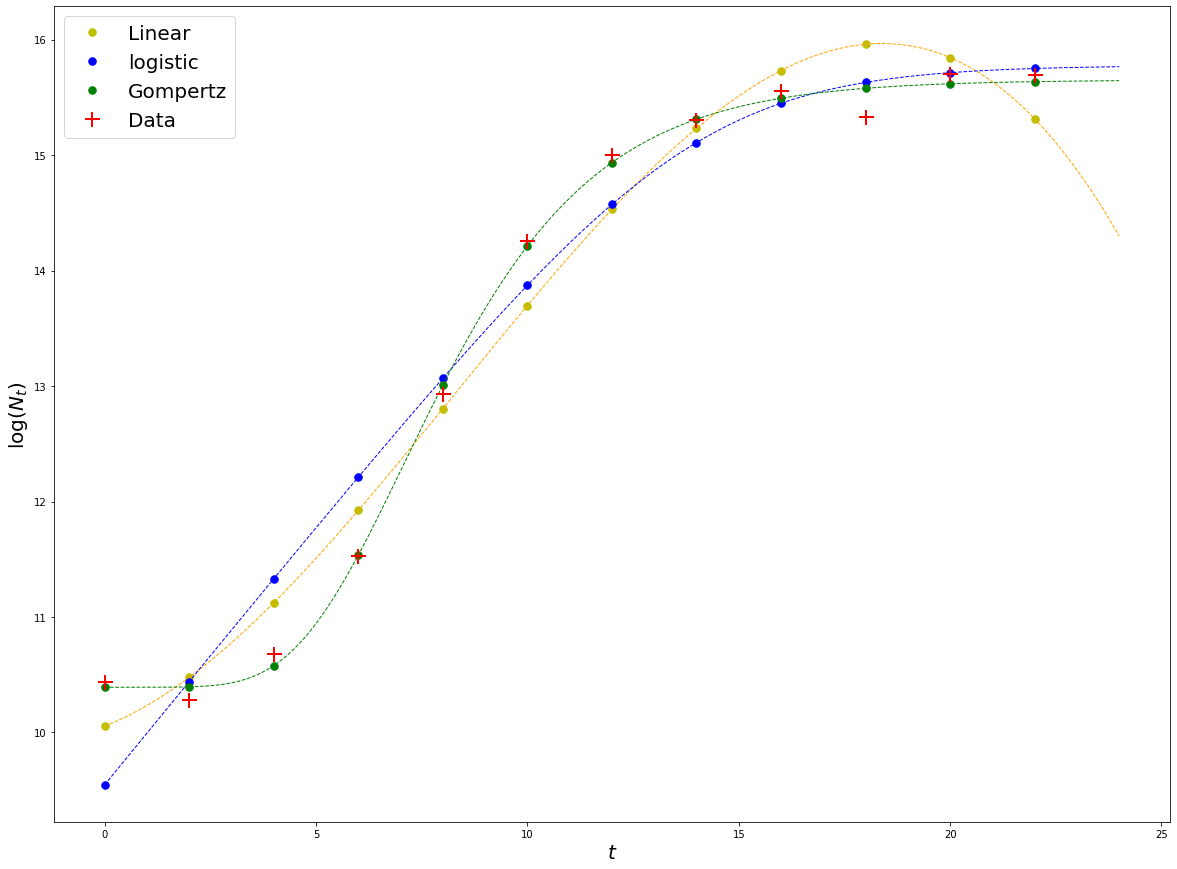

In [56]:
plt.rcParams['figure.figsize'] = [20, 15]
#Linear
result_linear = np.log(N_rand) + fit_linear_NLLS.residual
plt.plot(t, result_linear, 'y.', markersize = 15, label = "Linear")
# Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_linear = residuals_linear(fit_linear_NLLS.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_linear + log_N_vec, 'orange', linestyle = '--', linewidth = 1)

# Logistic
result_logistic = np.log(N_rand) + fit_logistic.residual
plt.plot(t, result_logistic, 'b.', markersize = 15, label = 'logistic')
# Get a smooth cure by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0, 24, 1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_logistic = residuals_logistic(fit_logistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_logistic + log_N_vec, 'blue', linestyle = '--', linewidth = 1)

# Gompertz
result_gompertz = np.log(N_rand) + fit_gompertz.residual
plt.plot(t, result_gompertz, 'g.', markersize = 15, label = 'Gompertz')
# Get a smooth curve by plugging a time vector to the fitted Gompertz model
t_vec = np.linspace(0, 24, 1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_gompertz = residuals_gompertz(fit_gompertz.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_gompertz + log_N_vec, 'green', linestyle = '--', linewidth = 1)

# Plot data points
plt.plot(t, np.log(N_rand), 'r+', markersize = 15, markeredgewidth = 2, label = 'Data')

# Plot legend
plt.legend(fontsize = 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$\log(N_t)$', fontsize = 20)
plt.ticklabel_format(style = 'scientific', scilimits = [0, 3])

## Richards' curve

In [51]:
# Define the parameter object
params_genlogistic = Parameters()
#Add parameters and initial values
params_genlogistic.add('A', value = 10, min = 0)
params_genlogistic.add('K', value = 16, min = 0)
params_genlogistic.add('Q', value = 0.5, min = 0)
params_genlogistic.add('B', value = 1, min = 0)
params_genlogistic.add('mu', value = 0.1, min = 0)
params_genlogistic.add('T', value = 7.5, min = 0)

In [58]:
# Define the model 
def residuals_genlogistic(params, t, data):
    ''' Model a logistic growth and substract data '''
    # Get an ordered dictionary of parameter values
    v = params.valuesdict()
    # Logistic model
    model = v['A'] + (v['K'] - v['A']) / \
    (1 + v['Q'] * np.exp(-v['B'] * (t - v['T']))) ** (1 / v['mu'])
    # Return residuals
    return model - data

In [59]:
# Perform the fit
## Create a minimizer
minner = Minimizer(residuals_genlogistic, params_genlogistic, fcn_args = (t, np.log(N_rand)))

# Perform the minimization
fit_genlogistic = minner.minimize()

In [60]:
report_fit(fit_genlogistic)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 12
    # variables        = 6
    chi-square         = 0.10205216
    reduced chi-square = 0.01700869
    Akaike info crit   = -45.2061349
    Bayesian info crit = -42.2966950
[[Variables]]
    A:   10.3556844 +/- 0.11496799 (1.11%) (init = 10)
    K:   15.6198051 +/- 0.07890403 (0.51%) (init = 16)
    Q:   1.29948606 +/- 794933.544 (61172917.98%) (init = 0.5)
    B:   0.43866161 +/- 0.07343543 (16.74%) (init = 1)
    mu:  0.26876764 +/- 0.39923962 (148.54%) (init = 0.1)
    T:   3.81422158 +/- 1394535.21 (36561462.98%) (init = 7.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, T)  = -1.000
    C(B, mu) =  0.893
    C(K, B)  = -0.634
    C(A, mu) = -0.585
    C(K, mu) = -0.457
    C(A, B)  = -0.357
    C(A, Q)  = -0.194
    C(A, T)  =  0.194
    C(A, K)  =  0.146


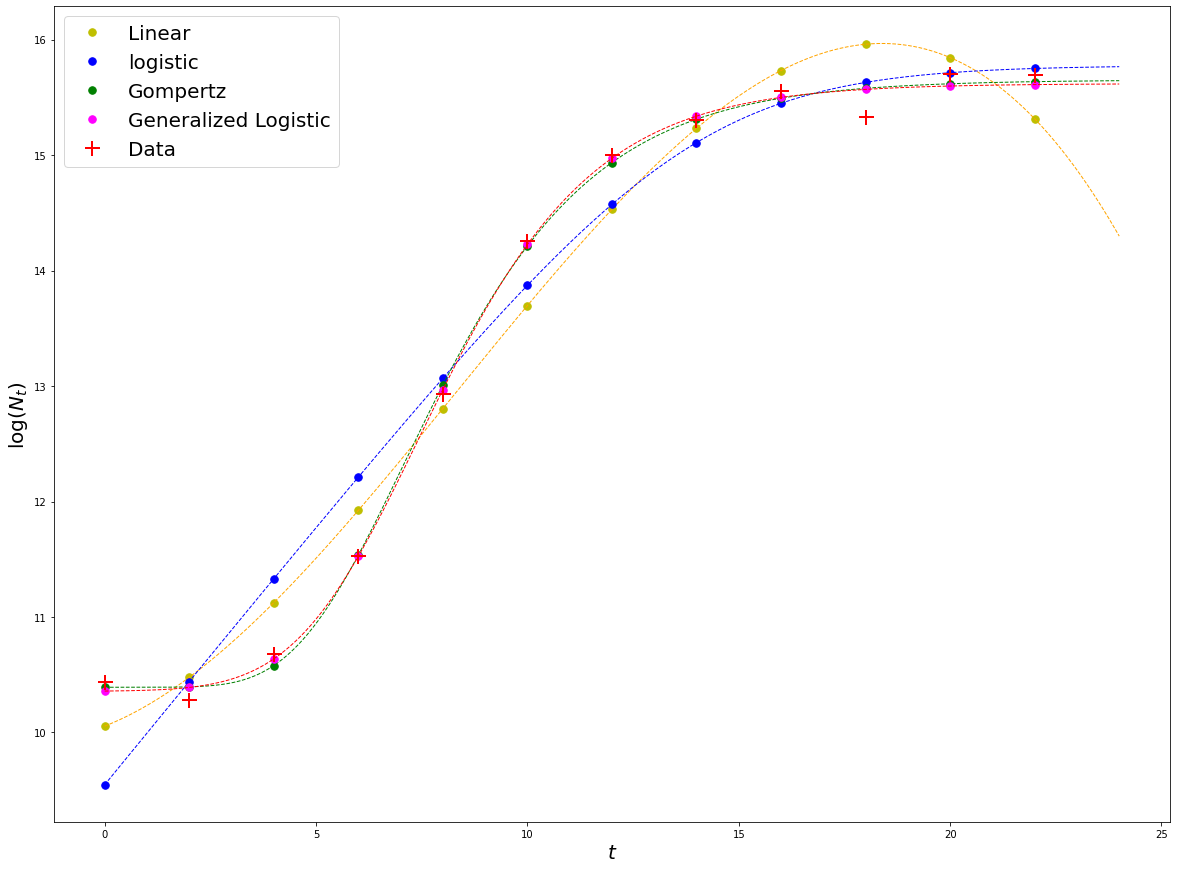

In [63]:
plt.rcParams['figure.figsize'] = [20, 15]
#Linear
result_linear = np.log(N_rand) + fit_linear_NLLS.residual
plt.plot(t, result_linear, 'y.', markersize = 15, label = "Linear")
# Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_linear = residuals_linear(fit_linear_NLLS.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_linear + log_N_vec, 'orange', linestyle = '--', linewidth = 1)

# Logistic
result_logistic = np.log(N_rand) + fit_logistic.residual
plt.plot(t, result_logistic, 'b.', markersize = 15, label = 'logistic')
# Get a smooth cure by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0, 24, 1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_logistic = residuals_logistic(fit_logistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_logistic + log_N_vec, 'blue', linestyle = '--', linewidth = 1)

# Gompertz
result_gompertz = np.log(N_rand) + fit_gompertz.residual
plt.plot(t, result_gompertz, 'g.', markersize = 15, label = 'Gompertz')
# Get a smooth curve by plugging a time vector to the fitted Gompertz model
t_vec = np.linspace(0, 24, 1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_gompertz = residuals_gompertz(fit_gompertz.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_gompertz + log_N_vec, 'green', linestyle = '--', linewidth = 1)

# Generalized Logistic
result_genlogistic = np.log(N_rand) + fit_genlogistic.residual
plt.plot(t, result_genlogistic, '.', markerfacecolor = 'magenta', markeredgecolor = 'magenta',
         markersize = 15, label = 'Generalized Logistic')
# Get a smooth curve by plugging a time vector to the fitted Gompertz model
t_vec = np.linspace(0, 24, 1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_genlogistic = residuals_genlogistic(fit_genlogistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_genlogistic + log_N_vec, 'red', linestyle = '--', linewidth = 1)

# Plot data points
plt.plot(t, np.log(N_rand), 'r+', markersize = 15, markeredgewidth = 2, label = 'Data')

# Plot legend
plt.legend(fontsize = 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$\log(N_t)$', fontsize = 20)
plt.ticklabel_format(style = 'scientific', scilimits = [0, 3])